In [1]:
import cv2
import time
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def visualize_fps(image, fps: int):
    # Check if the image is grayscale or colored.
    # If it's grayscale, set text color to white; if colored, set text color to green.
    if len(np.shape(image)) < 3:
        text_color = (255, 255, 255)  # White color for grayscale images.
    else:
        text_color = (0, 255, 0)  # Green color for colored images.

    # Define the row size for the text placement.
    row_size = 20 
    # Define the left margin for the text placement.
    left_margin = 24 

    # Set the font size and thickness for the text.
    font_size = 1
    font_thickness = 2

    # Format the FPS value into a string for displaying.
    fps_text = "FPS = {:.1f}".format(fps)
    # Set the text location on the image.
    text_location = (left_margin, row_size)
    
    # Place the FPS text on the image.
    cv2.putText(
        image,
        fps_text,
        text_location,
        cv2.FONT_HERSHEY_PLAIN,
        font_size,
        text_color,
        font_thickness,
    )

    # Return the modified image with the FPS text.
    return image

In [5]:
# Constants for camera settings
CAMERA_DEVICE_ID = 0  # ID for the camera device
IMAGE_WIDTH = 800  # Width of the captured image
IMAGE_HEIGHT = 600  # Height of the captured image
fps = 0  # Initial Frames Per Second (FPS) value

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  # Initialize video capture with the specified camera device ID

        while True:  # Infinite loop to continuously capture frames

            start_time = time.time()  # Record the start time to calculate FPS

            _, frame = cap.read()  # Capture a single frame from the camera

            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions

            # Display the frame with FPS overlay
            cv2.imshow("frame", visualize_fps(frame, fps)) 

            end_time = time.time()  # Record the end time to calculate FPS

            # Calculate the time taken to process the frame
            seconds = end_time - start_time 
            # Calculate FPS based on the time taken to process the frame
            fps = 1.0 / seconds

            # Break the loop if the 'Esc' key (ASCII 27) is pressed
            if cv2.waitKey(33) == 27:  
                break
    except Exception as e:  # Handle exceptions that may occur
        print(e)  # Print the exception message
    finally:
        cv2.destroyAllWindows()  # Close all OpenCV windows
        cap.release()  # Release the camera resource

In [6]:
# Constants for video settings
# Define the path to the video file using os.path.join
CAMERA_DEVICE_ID = os.path.join("./", "Einstein_2.mp4")  # Path to the video file
IMAGE_WIDTH = 1000  # Width of the displayed image
IMAGE_HEIGHT = 600  # Height of the displayed image
fps = 0  # Initial Frames Per Second (FPS) value
FRAME_RATE = 30  # Desired frame rate
DURATION = 1 / FRAME_RATE  # Duration of each frame

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  # Initialize video capture with the specified video file path

        while True:  # Infinite loop to continuously capture frames
            start_time = time.time()  # Record the start time to calculate FPS

            _, frame = cap.read()  # Capture a single frame from the video
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions

            end_time = time.time()  # Record the end time to calculate FPS

            # Calculate the time taken to process the frame
            seconds = end_time - start_time

            # If the processing time is less than the desired frame duration, wait for the remaining time
            if seconds < DURATION:
                time.sleep(DURATION - seconds)

            # Recalculate the time taken to process the frame including sleep time
            seconds = time.time() - start_time
            # Calculate FPS based on the time taken to process the frame
            fps = 1.0 / seconds

            # Display the frame with FPS overlay
            cv2.imshow("frame", visualize_fps(frame, fps))

            # Break the loop if the 'Esc' key (ASCII 27) is pressed
            if cv2.waitKey(33) == 27:  
                break
    except Exception as e:  # Handle exceptions that may occur
        print(e)  # Print the exception message
    finally:
        cv2.destroyAllWindows()  # Close all OpenCV windows
        cap.release()  # Release the video capture resource

در این قسمت مدل را بارگذاری می‌کنیم و برچسب های موردنظر را به او می‌دهیم مانند بازه سنی و جنسیت شخص

In [8]:
# File paths to the pre-trained models and configuration files.
# Define the paths to the model files using os.path.join
faceProto = os.path.join("models", "opencv_face_detector.pbtxt")
faceModel = os.path.join("models", "opencv_face_detector_uint8.pb")
ageProto = os.path.join("models", "age_deploy.prototxt")
ageModel = os.path.join("models", "age_net.caffemodel")
genderProto = os.path.join("models", "gender_deploy.prototxt")
genderModel = os.path.join("models", "gender_net.caffemodel")


# Mean values used for mean subtraction in preprocessing.
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
# List of age ranges corresponding to the output of the age detection model.
ageList = [
    "(0-2)",
    "(4-6)",
    "(8-12)",
    "(15-20)",
    "(25-32)",
    "(38-43)",
    "(48-53)",
    "(60-100)",
]
# List of gender labels corresponding to the output of the gender detection model.
genderList = ["Male", "Female"]

# Load the pre-trained models using the readNet function.
faceNet = cv2.dnn.readNet(faceModel, faceProto)
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)

در اینجا یک کپی از عکس ورودی میسازیم تا عکس اصلی دستکاری نشود و سعی میکنیم که یک چهره در آن بیابیم

In [9]:
def highlightFace(net, frame, conf_threshold=0.7):
    # Create a copy of the frame to avoid modifying the original image.
    frameOpencvDnn = frame.copy()
    # Get the height and width of the frame.
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    # Create a blob from the image for input to the neural network.
    blob = cv2.dnn.blobFromImage(
        frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False
    )

    # Set the input for the network.
    net.setInput(blob)
    # Perform forward pass to get the detections.
    detections = net.forward()
    # Initialize an empty list to store face bounding boxes.
    faceBoxes = []
    # Iterate over all detections.
    for i in range(detections.shape[2]):
        # Get the confidence for the detection.
        confidence = detections[0, 0, i, 2]
        # Check if the detection confidence is above the threshold.
        if confidence > conf_threshold:
            # Get the coordinates of the bounding box.
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            # Append the bounding box to the list.
            faceBoxes.append([x1, y1, x2, y2])
            # Draw the bounding box on the frame.
            cv2.rectangle(
                frameOpencvDnn,
                (x1, y1),
                (x2, y2),
                (0, 255, 0),
                int(round(frameHeight / 150)),
                8,
            )
    # Return the frame with bounding boxes and the list of bounding boxes.
    return frameOpencvDnn, faceBoxes

اینجا هم خروجی قسمت قبلی را میگیریم و به شبکه عصبی میدهیم تا روی آن آنالیز انجام دهد

In [12]:
def detect_face_age_gender(frame, padding=20):
    # Highlight faces in the frame using the highlightFace function
    resultImg, faceBoxes = highlightFace(faceNet, frame)
    if not faceBoxes:  # Check if any faces were detected
        print("No face detected")
    # Iterate over the detected face bounding boxes
    for faceBox in faceBoxes:
        # Crop the face region with padding
        face = frame[
            max(0, faceBox[1] - padding) : min(
                faceBox[3] + padding, frame.shape[0] - 1
            ),
            max(0, faceBox[0] - padding) : min(
                faceBox[2] + padding, frame.shape[1] - 1
            ),
        ]
    
    # Create a blob from the face region for input to the neural networks
    blob = cv2.dnn.blobFromImage(
        face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False
    )
    
    # Predict gender using the gender detection model
    genderNet.setInput(blob)
    genderPreds = genderNet.forward()
    gender = genderList[genderPreds[0].argmax()]
    # Predict age using the age detection model
    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    age = ageList[agePreds[0].argmax()]
    # Overlay the gender and age prediction on the image
    cv2.putText(
        resultImg,
        f"{gender}, {age}",
        (faceBox[0], faceBox[1] - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 255),
        2,
        cv2.LINE_AA,
    )
    return resultImg

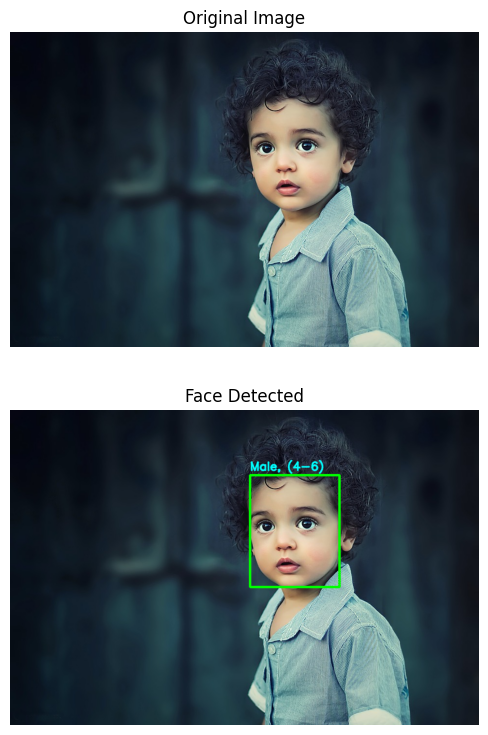

In [13]:
IMAGE_ADDRESS = os.path.join("./", "kid1.jpg")
image = cv2.imread(IMAGE_ADDRESS)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
result = detect_face_age_gender(image)

plt.figure(figsize=(18, 9))
plt.subplot(2, 1, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(2, 1, 2)
plt.imshow(result)
plt.title("Face Detected")
plt.axis("off")

plt.show()

In [14]:
def detect_face_age_gender(frame, padding=20):
    # Highlight faces in the frame using the highlightFace function
    resultImg, faceBoxes = highlightFace(faceNet, frame)
    if not faceBoxes:  # Check if any faces were detected
        print("No face detected")
    # Iterate over the detected face bounding boxes
    for faceBox in faceBoxes:
        # Crop the face region with padding
        face = frame[
            max(0, faceBox[1] - padding) : min(
                faceBox[3] + padding, frame.shape[0] - 1
            ),
            max(0, faceBox[0] - padding) : min(
                faceBox[2] + padding, frame.shape[1] - 1
            ),
        ]
    
    # Create a blob from the face region for input to the neural networks
    blob = cv2.dnn.blobFromImage(
        face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False
    )
    
    # Predict gender using the gender detection model
    genderNet.setInput(blob)
    genderPreds = genderNet.forward()
    gender = genderList[genderPreds[0].argmax()]
    # Predict age using the age detection model
    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    age = ageList[agePreds[0].argmax()]
    # Overlay the gender and age prediction on the image
    cv2.putText(
        resultImg,
        f"{gender}, {age}",
        (faceBox[0], faceBox[1] - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 255),
        2,
        cv2.LINE_AA,
    )
    return resultImg

In [21]:
# Constants for camera settings
CAMERA_DEVICE_ID = 0  # ID for the camera device
IMAGE_WIDTH = 800  # Width of the captured image
IMAGE_HEIGHT = 600  # Height of the captured image
fps = 0  # Initial Frames Per Second (FPS) value
padding = 20  # Padding around the detected face for cropping

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  # Initialize video capture with the specified camera device ID

        while True:  # Infinite loop to continuously capture frames

            start_time = time.time()  # Record the start time to calculate FPS

            hasFrame, frame = cap.read()  # Capture a single frame from the camera
            if not hasFrame:  # Check if the frame was captured successfully
                cv2.waitKey()  # Wait indefinitely for a key event
                break  # Exit the loop if no frame is captured

            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions
            
            resultImg = detect_face_age_gender(frame)

            # Display the frame with FPS overlay
            cv2.imshow("Detecting age and gender", visualize_fps(resultImg, fps))

            end_time = time.time()  # Record the end time to calculate FPS

            # Calculate the time taken to process the frame
            seconds = end_time - start_time
            # Calculate FPS based on the time taken to process the frame
            fps = 1.0 / seconds

            # Break the loop if the 'Esc' key (ASCII 27) is pressed
            if cv2.waitKey(33) == 27:
                break
    except Exception as e:  # Handle exceptions that may occur
        print(e)  # Print the exception message
    finally:
        cv2.destroyAllWindows()  # Close all OpenCV windows
        cap.release()  # Release the camera resource

No face detected
cannot access local variable 'face' where it is not associated with a value


In [19]:
# Constants for video settings
# Define the path to the video file using os.path.join
CAMERA_DEVICE_ID = os.path.join("./", "Jobs_2.mp4")  # Path to the video file
IMAGE_WIDTH = 1000  # Width of the displayed image
IMAGE_HEIGHT = 600  # Height of the displayed image
fps = 0  # Initial Frames Per Second (FPS) value
FRAME_RATE = 30  # Desired frame rate
DURATION = 1 / FRAME_RATE  # Duration of each frame

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  # Initialize video capture with the specified video file path

        while True:  # Infinite loop to continuously capture frames
            start_time = time.time()  # Record the start time to calculate FPS

            hasFrame, frame = cap.read()  # Capture a single frame from the video

            if not hasFrame:  # Check if the frame was captured successfully
                cv2.waitKey()  # Wait indefinitely for a key event
                break  # Exit the loop if no frame is captured

            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions
            
            resultImg = detect_face_age_gender(frame)

            # Display the frame with FPS overlay
            cv2.imshow("Detecting age and gender", visualize_fps(resultImg, fps))

            end_time = time.time()  # Record the end time to calculate FPS

            # Calculate the time taken to process the frame
            seconds = end_time - start_time

            # If the processing time is less than the desired frame duration, wait for the remaining time
            if seconds < DURATION:
                time.sleep(DURATION - seconds)

            # Recalculate the time taken to process the frame including sleep time
            seconds = time.time() - start_time
            # Calculate FPS based on the time taken to process the frame
            fps = 1.0 / seconds

            # Break the loop if the 'Esc' key (ASCII 27) is pressed
            if cv2.waitKey(33) == 27:
                break
    except Exception as e:  # Handle exceptions that may occur
        print(e)  # Print the exception message
    finally:
        cv2.destroyAllWindows()  # Close all OpenCV windows
        cap.release()  # Release the video capture resource